# An Initial Exploration of LIV + UV KASH cells image analysis

## Data Loading and Preprocessing

In [271]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from itertools import combinations
from statannotations.Annotator import Annotator

In [272]:
file_path = r"D:\BioLab\Current_experiments\Anamaria_3d_experiment\17.10.2023_analysis_data\cell_stat_corrected_combined.csv"
initial_df = pd.read_csv(file_path)
initial_df = initial_df.dropna(how='all')
initial_df

,Image_name,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 has ring,AF488-T3 ring intensity coef
1,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,0.0,0.0,1195.989526,34.615588,27.981643,4.37,2167.151385,False,0.332799,637.101337,False,0.911314,777.721096,False,0.383467
3,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,0.0,1.0,905.465930,27.386289,33.084678,4.14,1580.094375,False,0.308308,564.649640,False,0.716645,485.127689,False,0.431648
5,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,0.0,2.0,1660.530804,39.123269,27.811542,4.37,2642.460360,False,0.342131,596.328584,False,0.803914,894.602170,False,0.394431
7,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,1.0,0.0,1330.354735,28.747098,38.357814,3.68,2469.800347,False,0.324591,1048.006392,False,1.044872,1015.352081,False,0.386187
9,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,2.0,0.0,960.556972,27.981643,33.424880,4.37,1693.773549,False,0.349580,61.642229,False,0.995792,321.775153,False,0.563587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,15.0,1.0,1069.924659,36.486701,30.618211,3.45,5555.741990,False,0.425720,145.633905,False,0.897390,794.961516,False,0.449208
1285,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,16.0,0.0,4120.998073,41.334585,39.208320,5.52,6843.074518,False,0.472910,155.117297,True,1.134145,554.541681,False,0.832314
1287,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,17.0,0.0,2849.592565,44.481456,50.009744,3.68,4410.573773,False,0.371503,149.746000,False,0.929955,609.439689,False,0.524116
1289,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,18.0,0.0,2270.910363,35.891347,29.512553,5.06,11352.510000,False,0.322937,130.899760,False,0.910103,505.702978,False,0.526133


In [273]:
def extract_info(image_name):
    date_pattern = re.compile(r'\d+-\d+-\d+')
    date = date_pattern.search(image_name).group(0)

    type = "KASH" if "KASH" in image_name else "MSC"

    doxy = "+doxy" if "+doxy" in image_name else "-doxy"

    liv = "+LIV" if "+LIV" in image_name else "-LIV"

    treatment = "cisp" if "cisp" in image_name else "control"

    time_pattern = re.compile(r'0hr|24hr|48hr|72hr')
    time = time_pattern.search(image_name).group(0)

    return pd.Series([date, type, doxy, liv, treatment, time], index=['Date', 'Cell_type','Doxy', 'LIV', 'Treatment', 'Time'])



In [274]:
# Extract the information into temporary DataFrame
temp_df = initial_df['Image_name'].apply(extract_info)

# Find the index of the "Image_name" column
idx = initial_df.columns.get_loc('Image_name') + 1

# Insert the new columns
for col in reversed(temp_df.columns):
    initial_df.insert(loc=idx, column=col, value=temp_df[col])


In [275]:
initial_df

,Image_name,Date,Cell_type,Doxy,LIV,Treatment,Time,Img_num,Cell_num,"Nucleus_volume, cubic_micrometre",...,"Nucleus_high, micrometre",Cy5-T1 av_signal_in_nuc_area_3D,Cy5-T1 has ring,Cy5-T1 ring intensity coef,AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,AF488-T3 has ring,AF488-T3 ring intensity coef
1,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,23-8-28,KASH,+doxy,-LIV,cisp,0hr,0.0,0.0,1195.989526,...,4.37,2167.151385,False,0.332799,637.101337,False,0.911314,777.721096,False,0.383467
3,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,23-8-28,KASH,+doxy,-LIV,cisp,0hr,0.0,1.0,905.465930,...,4.14,1580.094375,False,0.308308,564.649640,False,0.716645,485.127689,False,0.431648
5,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,23-8-28,KASH,+doxy,-LIV,cisp,0hr,0.0,2.0,1660.530804,...,4.37,2642.460360,False,0.342131,596.328584,False,0.803914,894.602170,False,0.394431
7,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,23-8-28,KASH,+doxy,-LIV,cisp,0hr,1.0,0.0,1330.354735,...,3.68,2469.800347,False,0.324591,1048.006392,False,1.044872,1015.352081,False,0.386187
9,LSM processed-23-8-28 KASH+doxy -LIV cisp 10uM...,23-8-28,KASH,+doxy,-LIV,cisp,0hr,2.0,0.0,960.556972,...,4.37,1693.773549,False,0.349580,61.642229,False,0.995792,321.775153,False,0.563587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,23-8-28,MSC,-doxy,+LIV,cisp,48hr,15.0,1.0,1069.924659,...,3.45,5555.741990,False,0.425720,145.633905,False,0.897390,794.961516,False,0.449208
1285,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,23-8-28,MSC,-doxy,+LIV,cisp,48hr,16.0,0.0,4120.998073,...,5.52,6843.074518,False,0.472910,155.117297,True,1.134145,554.541681,False,0.832314
1287,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,23-8-28,MSC,-doxy,+LIV,cisp,48hr,17.0,0.0,2849.592565,...,3.68,4410.573773,False,0.371503,149.746000,False,0.929955,609.439689,False,0.524116
1289,LSM processed-23-8-28 MSC +LIV cisp 10uM 6x vi...,23-8-28,MSC,-doxy,+LIV,cisp,48hr,18.0,0.0,2270.910363,...,5.06,11352.510000,False,0.322937,130.899760,False,0.910103,505.702978,False,0.526133


In [276]:
initial_df.columns

Index(['Image_name', 'Date', 'Cell_type', 'Doxy', 'LIV', 'Treatment', 'Time',
       'Img_num', 'Cell_num', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_length, micrometre', 'Nucleus_width, micrometre',
       'Nucleus_high, micrometre', 'Cy5-T1 av_signal_in_nuc_area_3D',
       'Cy5-T1 has ring', 'Cy5-T1 ring intensity coef',
       'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D',
       'AF488-T3 has ring', 'AF488-T3 ring intensity coef'],
      dtype='object')

In [277]:
filtered_df = initial_df[['Image_name', 'Img_num','Cell_num', 'Cell_type', 'Doxy', 'LIV', 'Treatment', 'Time', 'Nucleus_volume, cubic_micrometre',
       'Nucleus_length, micrometre', 'Nucleus_width, micrometre',
       'Nucleus_high, micrometre', 'AF594-T2 av_signal_in_nuc_area_3D', 'AF594-T2 has ring',
       'AF594-T2 ring intensity coef', 'AF488-T3 av_signal_in_nuc_area_3D']]

C:\Users\nnina\AppData\Local\Temp\ipykernel_12664\566569122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Group'] = filtered_df['Doxy'] + ', ' + filtered_df['Cell_type'] + ', ' + filtered_df['LIV'] + ', ' + filtered_df['Treatment'] + ', ' + filtered_df['Time']


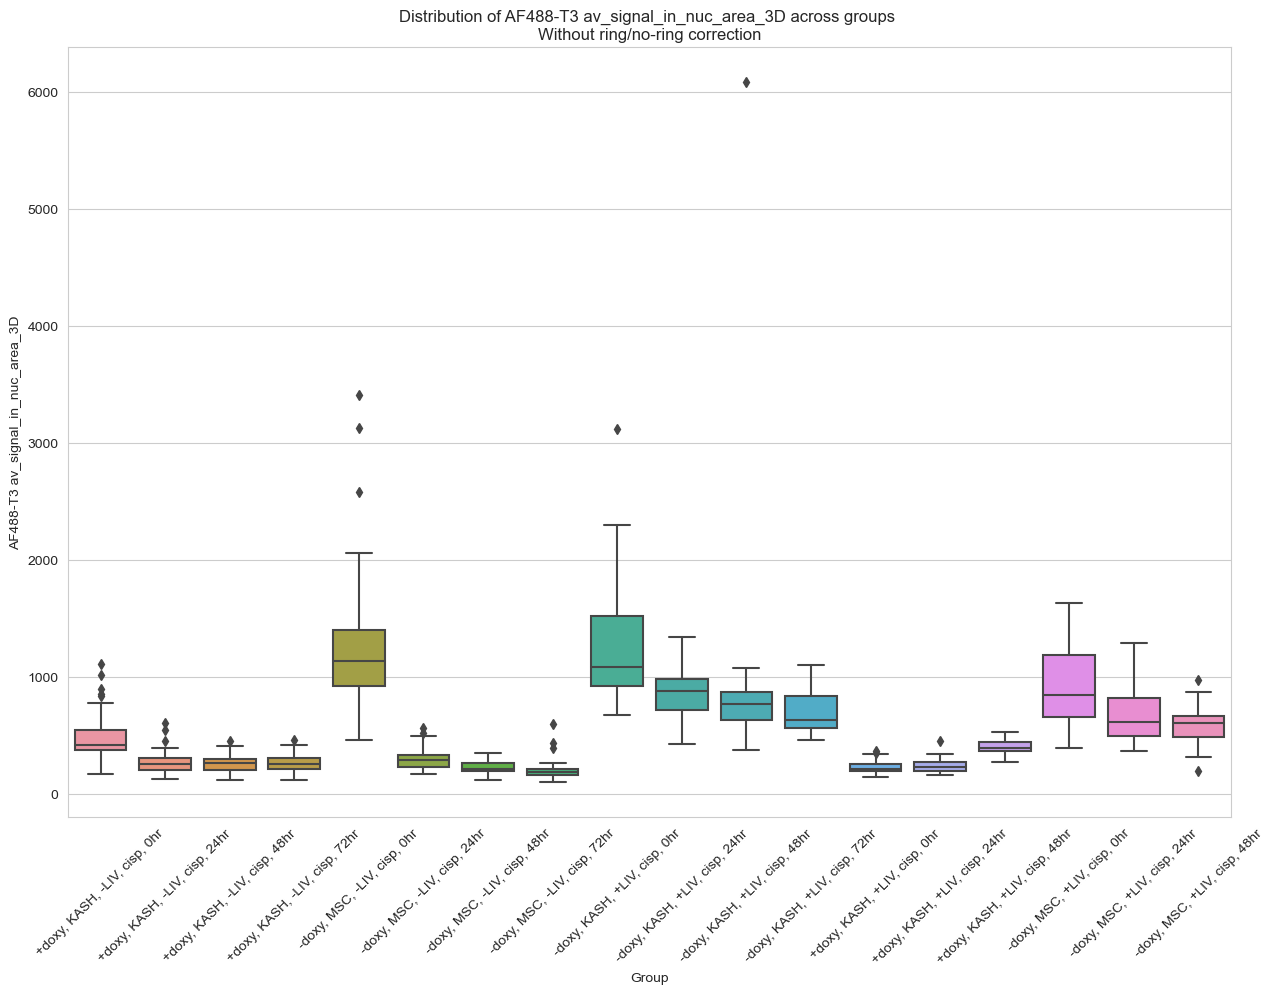

In [278]:
filtered_df['Group'] = filtered_df['Doxy'] + ', ' + filtered_df['Cell_type'] + ', ' + filtered_df['LIV'] + ', ' + filtered_df['Treatment'] + ', ' + filtered_df['Time']
plt.figure(figsize=(15, 10))
sns.boxplot(x='Group', y='AF488-T3 av_signal_in_nuc_area_3D', data=filtered_df)
plt.title('Distribution of AF488-T3 av_signal_in_nuc_area_3D across groups \nWithout ring/no-ring correction')
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
plt.savefig('figures/Distribution of AF488-T3 av_signal_in_nuc_area_3D across groups.png', dpi=300, bbox_inches='tight')
plt.show()

## Total repair signal within nucleus area

New column titled "AF488-T3 Volume_corrected_signal_in_nuc_area_3D." This will display the repair signal within each nucleus in its entirety. The value is derived from the background-corrected average signal.

In [279]:
resolution = 0.085 * 0.058 * 0.230 #x.resolution * y.resolution * z.resolution
filtered_df['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D'] * filtered_df['Nucleus_volume, cubic_micrometre']

C:\Users\nnina\AppData\Local\Temp\ipykernel_12664\3239532789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] = filtered_df['AF488-T3 av_signal_in_nuc_area_3D'] * filtered_df['Nucleus_volume, cubic_micrometre']


In [280]:
RING_CUTT_OFF_COEF = 0.9
filtered_df['AF594-T2 has ring'] = filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF

with pd.ExcelWriter('raw_data.xlsx') as writer:
    filtered_df.to_excel(writer, index=False)

filtered_df.to_csv('raw_data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

C:\Users\nnina\AppData\Local\Temp\ipykernel_12664\2017294269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['AF594-T2 has ring'] = filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF


## KASH -Doxy +LIV


In [281]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
minus_doxy_plus_cisp_plus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Cell_type'] == 'KASH') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

minus_doxy_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Cell_type'] == 'KASH') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_vol_cor = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
minus_doxy_plus_cisp_plus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr_vol_cor
average_0hr_without_cor = minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
minus_doxy_plus_cisp_plus_liv_no_ring_df.loc[:, 'AF488-T3 av_signal_in_nuc_area_3D'] /= average_0hr_without_cor

print(f"Total -Doxy KASH +LIV +Cisp: {len(minus_doxy_plus_cisp_plus_liv_df)}")
print(f"No ring -Doxy KASH +LIV +Cisp: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df)}\n "
      f"0hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr'])}\n"
      f"24hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '24hr'])}\n"
      f"48hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr'])}\n"
      f"72hr: {len(minus_doxy_plus_cisp_plus_liv_no_ring_df[minus_doxy_plus_cisp_plus_liv_no_ring_df['Time'] == '72hr'])}\n")

Total -Doxy KASH +LIV +Cisp: 129
No ring -Doxy KASH +LIV +Cisp: 95
 0hr: 17
24hr: 31
48hr: 33
72hr: 14



In [282]:
# Custom colors
blue = (0.298, 0.447, 0.690)  # a desaturated blue color
orange = (1.0, 0.498, 0.055)  # a desaturated orange color
green = (0, 0.498, 0)
red = (1, 0, 0)
pal = [blue, orange, green, red]


configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr'),
                           ('0hr','24hr'),
                           ('0hr','72hr'),
                           ('24hr','48hr'),
                           ('24hr','72hr'),
                           ('48hr','72hr')]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.516e-03 U_stat=3.880e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.830e-02 U_stat=6.590e+02
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.049e-01 U_stat=2.860e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.670e-04 U_stat=4.590e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.116e-02 U_stat=3.210e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.812e-04 U_stat=2.110e+02


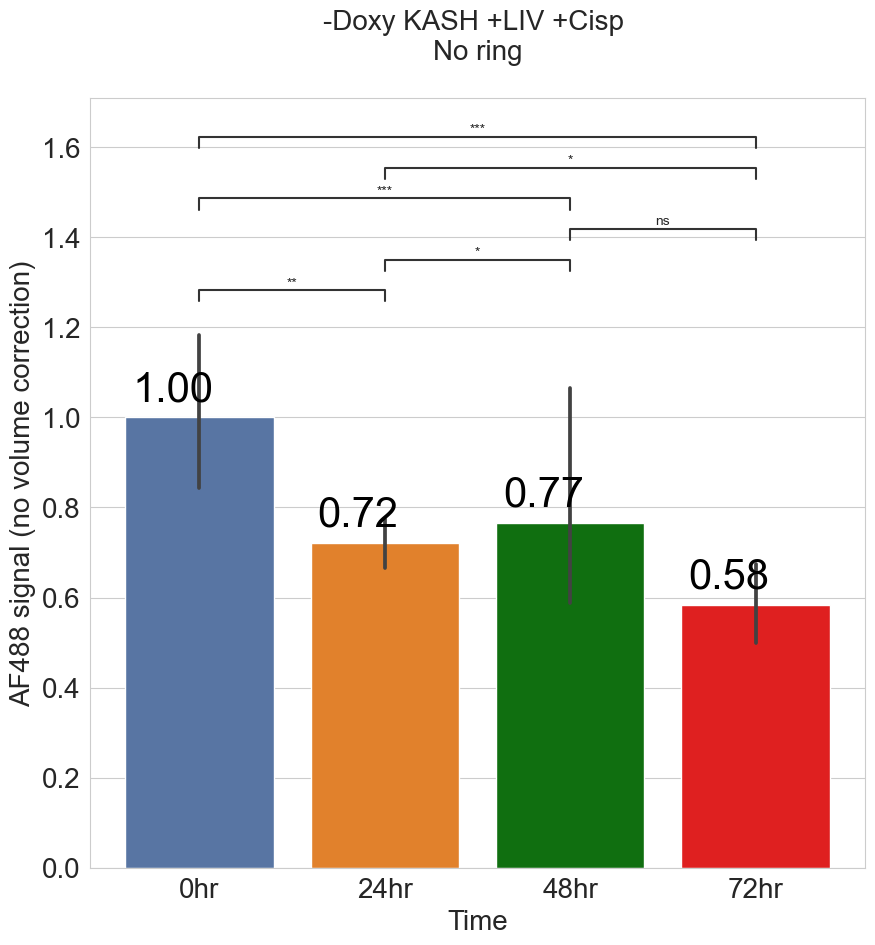

In [283]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 av_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy KASH +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal (no volume correction)', fontsize=20)

plt.savefig('figures/av_signal_KASH -Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:6.200e-01 U_stat=2.870e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.984e-02 U_stat=3.650e+02
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.209e-02 U_stat=3.150e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.785e-01 U_stat=2.370e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:6.326e-01 U_stat=2.370e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.934e-01 U_stat=1.410e+02


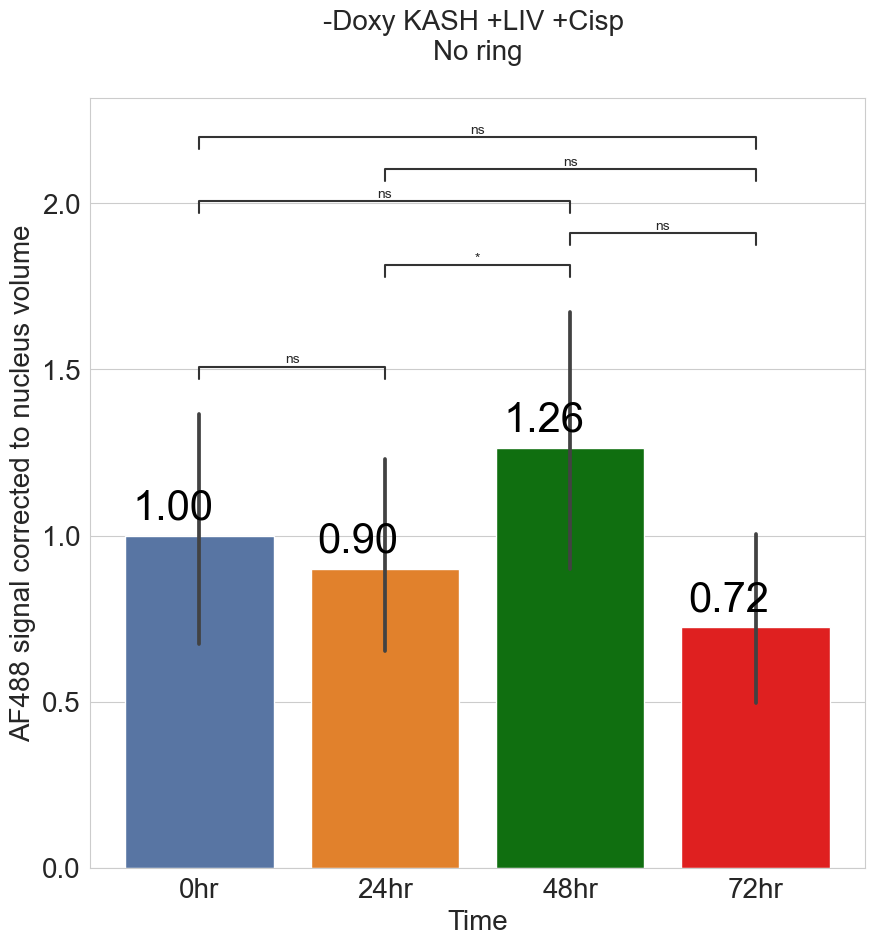

In [284]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': minus_doxy_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy KASH +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal corrected to nucleus volume', fontsize=20)

plt.savefig('figures/volume_corrected_KASH -Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.768e-01 U_stat=2.300e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.560e-02 U_stat=3.310e+02
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.904e-02 U_stat=3.070e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.129e-03 U_stat=1.210e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:6.152e-01 U_stat=1.960e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.928e-01 U_stat=9.200e+01


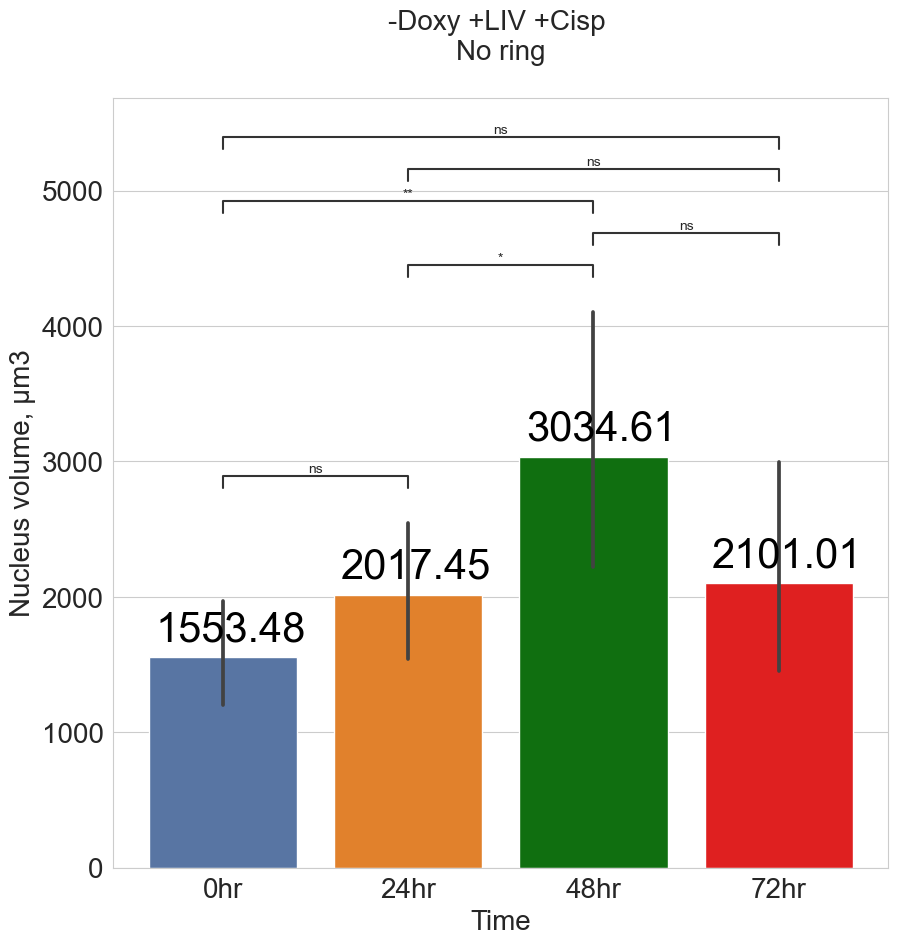

In [285]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': minus_doxy_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('-Doxy +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus volume, µm3', fontsize=20)

plt.savefig('figures/-Doxy +LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

## KASH+Doxy +LIV +Cisp

In [286]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr'),
                           ('0hr','24hr'),
                           ('24hr','48hr')]

In [287]:
RING_CUTT_OFF_COEF = 0.9
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
plus_doxy_plus_cisp_plus_liv_with_ring_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['Cell_type'] == 'KASH') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF)].copy()

plus_doxy_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Cell_type'] == 'KASH') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_vol_cor = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
plus_doxy_plus_cisp_plus_liv_with_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr_vol_cor
print(f"Total +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_df)}")

average_0hr_without_cor = plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
plus_doxy_plus_cisp_plus_liv_with_ring_df.loc[:, 'AF488-T3 av_signal_in_nuc_area_3D'] /= average_0hr_without_cor
print(f"Total +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_df)}")

print(f"With ring +Doxy +LIV +Cisp: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df)}\n "
      f"0hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '0hr'])}\n"
      f"24hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '24hr'])}\n"
      f"48hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '48hr'])}\n"
      f"72hr: {len(plus_doxy_plus_cisp_plus_liv_with_ring_df[plus_doxy_plus_cisp_plus_liv_with_ring_df['Time'] == '72hr'])}")

Total +Doxy +LIV +Cisp: 104
Total +Doxy +LIV +Cisp: 104
With ring +Doxy +LIV +Cisp: 34
 0hr: 15
24hr: 10
48hr: 9
72hr: 0


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.139e-01 U_stat=1.040e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.797e-04 U_stat=0.000e+00
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.040e-03 U_stat=1.200e+01


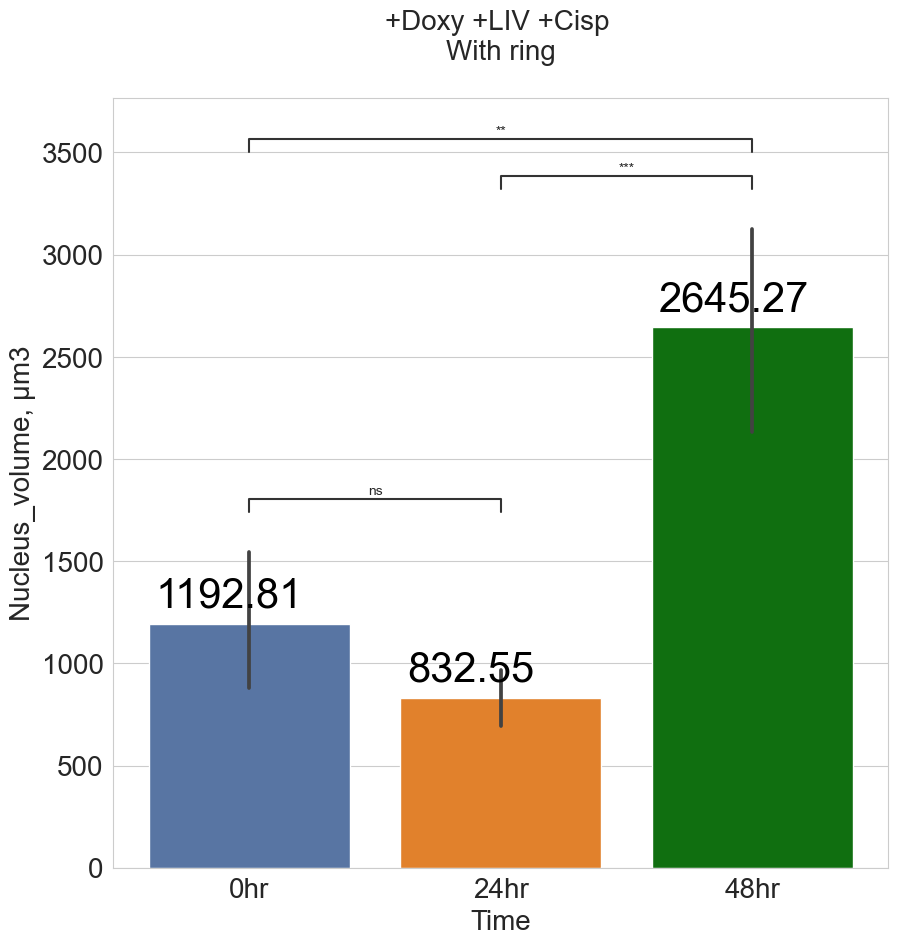

In [288]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': plus_doxy_plus_cisp_plus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy +LIV +Cisp \nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/+Doxy +LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.337e-01 U_stat=7.300e+01
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.029e-04 U_stat=3.000e+00
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.355e-04 U_stat=3.000e+00


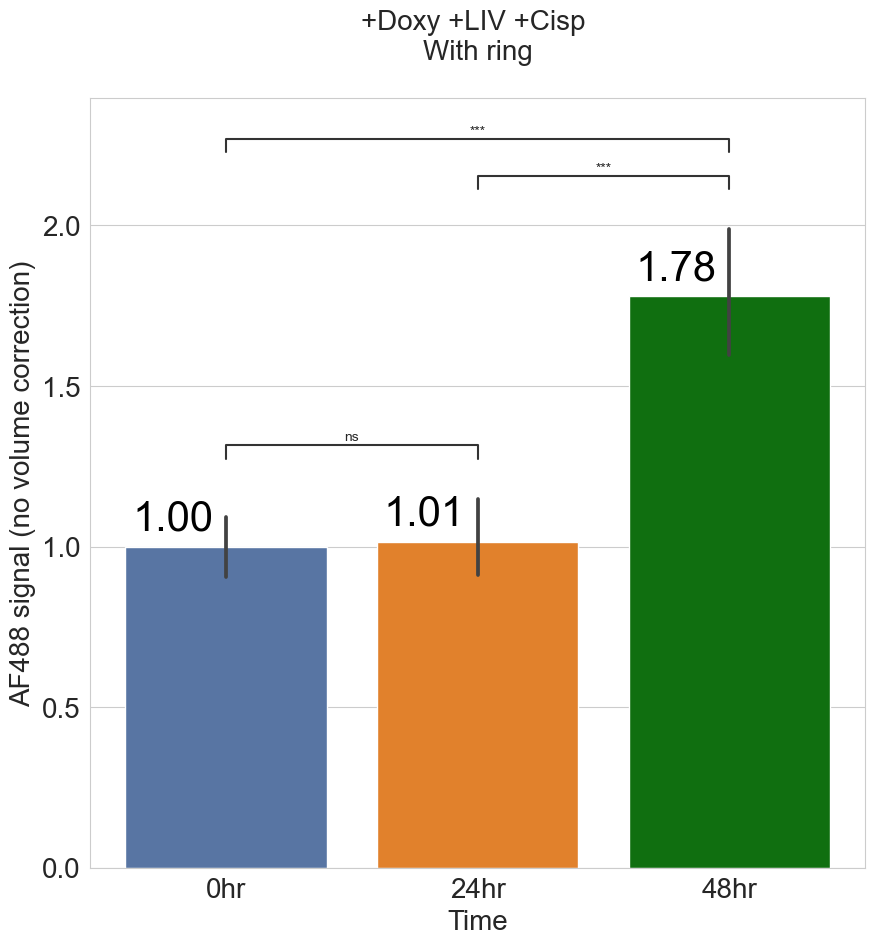

In [289]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 av_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_plus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy +LIV +Cisp \nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal (no volume correction)', fontsize=20)

plt.savefig('figures/av_signal_KASH +Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

In [290]:
plus_doxy_plus_cisp_plus_liv_with_ring_df

,Image_name,Img_num,Cell_num,Cell_type,Doxy,LIV,Treatment,Time,"Nucleus_volume, cubic_micrometre","Nucleus_length, micrometre","Nucleus_width, micrometre","Nucleus_high, micrometre",AF594-T2 av_signal_in_nuc_area_3D,AF594-T2 has ring,AF594-T2 ring intensity coef,AF488-T3 av_signal_in_nuc_area_3D,Group,AF488-T3 Volume_corrected_signal_in_nuc_area_3D
891,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,89.0,0.0,KASH,+doxy,+LIV,cisp,0hr,1829.573106,29.682654,35.040841,4.14,792.791693,True,0.941412,0.857736,"+doxy, KASH, +LIV, cisp, 0hr",1.295000
893,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,89.0,1.0,KASH,+doxy,+LIV,cisp,0hr,1255.801398,27.726491,26.280631,5.06,796.933958,True,1.067808,0.987322,"+doxy, KASH, +LIV, cisp, 0hr",1.023166
897,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,91.0,0.0,KASH,+doxy,+LIV,cisp,0hr,2011.830403,28.662047,37.337207,5.06,990.784974,True,1.000586,1.118759,"+doxy, KASH, +LIV, cisp, 0hr",1.857352
899,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,91.0,1.0,KASH,+doxy,+LIV,cisp,0hr,478.503287,14.373549,18.711129,3.91,652.944836,True,0.995936,0.936171,"+doxy, KASH, +LIV, cisp, 0hr",0.369663
911,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,94.0,0.0,KASH,+doxy,+LIV,cisp,0hr,845.743068,18.370927,18.455977,5.29,1166.404738,True,0.938822,1.387230,"+doxy, KASH, +LIV, cisp, 0hr",0.968173
929,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,98.0,0.0,KASH,+doxy,+LIV,cisp,0hr,331.778240,25.089923,11.396778,6.67,79.270387,True,0.950561,0.651703,"+doxy, KASH, +LIV, cisp, 0hr",0.178428
931,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,98.0,1.0,KASH,+doxy,+LIV,cisp,0hr,803.486028,16.159611,18.796179,5.52,791.484786,True,1.250387,1.237918,"+doxy, KASH, +LIV, cisp, 0hr",0.820798
933,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,98.0,2.0,KASH,+doxy,+LIV,cisp,0hr,780.640541,16.754965,17.180218,5.52,770.397999,True,1.220367,1.299898,"+doxy, KASH, +LIV, cisp, 0hr",0.837388
937,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,98.0,4.0,KASH,+doxy,+LIV,cisp,0hr,1092.240250,23.644063,25.940429,4.14,690.713399,True,1.000050,0.849518,"+doxy, KASH, +LIV, cisp, 0hr",0.765697
949,LSM processed-23-8-28 KASH+doxy +LIV cisp 10uM...,101.0,0.0,KASH,+doxy,+LIV,cisp,0hr,1237.832298,26.110530,22.623456,6.67,631.962939,True,1.091242,1.002536,"+doxy, KASH, +LIV, cisp, 0hr",1.024066


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.794e-01 U_stat=9.500e+01
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.827e-04 U_stat=1.000e+00
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.355e-04 U_stat=3.000e+00


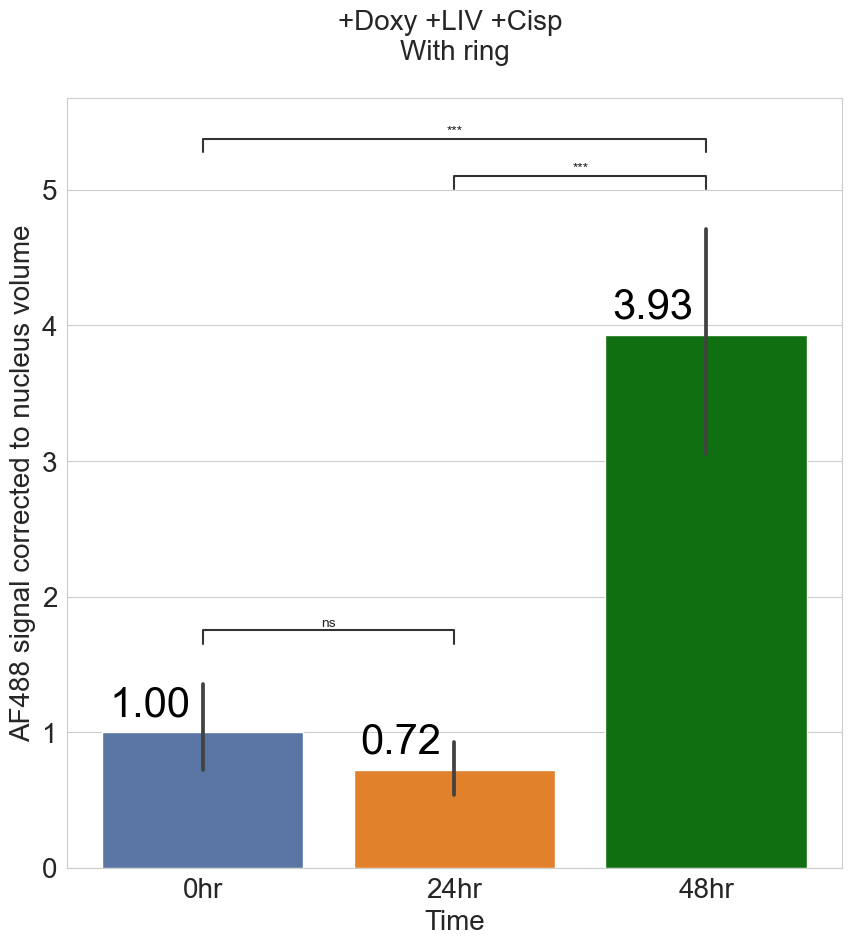

In [291]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_plus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy +LIV +Cisp \nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal corrected to nucleus volume', fontsize=20)

plt.savefig('figures/volume_corrected_KASH +Doxy +LIV +Cisp.png', dpi=300, bbox_inches='tight')

## MSC -LIV +Cisp

In [292]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr'),
                           ('0hr','24hr'),
                           ('0hr','72hr'),
                           ('24hr','48hr'),
                           ('24hr','72hr'),
                           ('48hr','72hr')]

In [293]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
mcs_plus_cisp_minus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['Cell_type'] == 'MSC') & (filtered_df['LIV'] == '-LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

msc_plus_cisp_minus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['Cell_type'] == 'MSC') & (filtered_df['LIV'] == '-LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_vol_cor = mcs_plus_cisp_minus_liv_no_ring_df[mcs_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
mcs_plus_cisp_minus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr_vol_cor

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_without_cor = mcs_plus_cisp_minus_liv_no_ring_df[mcs_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
mcs_plus_cisp_minus_liv_no_ring_df.loc[:, 'AF488-T3 av_signal_in_nuc_area_3D'] /= average_0hr_without_cor

print(f"Total MSC -LIV +Cisp: {len(msc_plus_cisp_minus_liv_df)}")
print(f"No ring MSC -LIV +Cisp: {len(mcs_plus_cisp_minus_liv_no_ring_df)}\n"
      f"0hr: {len(mcs_plus_cisp_minus_liv_no_ring_df[mcs_plus_cisp_minus_liv_no_ring_df['Time'] == '0hr'])}\n"
      f"24hr: {len(mcs_plus_cisp_minus_liv_no_ring_df[mcs_plus_cisp_minus_liv_no_ring_df['Time'] == '24hr'])}\n"
      f"48hr: {len(mcs_plus_cisp_minus_liv_no_ring_df[mcs_plus_cisp_minus_liv_no_ring_df['Time'] == '48hr'])}\n"
      f"72hr: {len(mcs_plus_cisp_minus_liv_no_ring_df[mcs_plus_cisp_minus_liv_no_ring_df['Time'] == '72hr'])}\n")

Total MSC -LIV +Cisp: 163
No ring MSC -LIV +Cisp: 126
0hr: 49
24hr: 23
48hr: 19
72hr: 35



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.267e-10 U_stat=1.081e+03
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.589e-02 U_stat=1.390e+02
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.486e-02 U_stat=4.390e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.387e-07 U_stat=8.440e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.612e-01 U_stat=4.140e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.924e-12 U_stat=1.610e+03


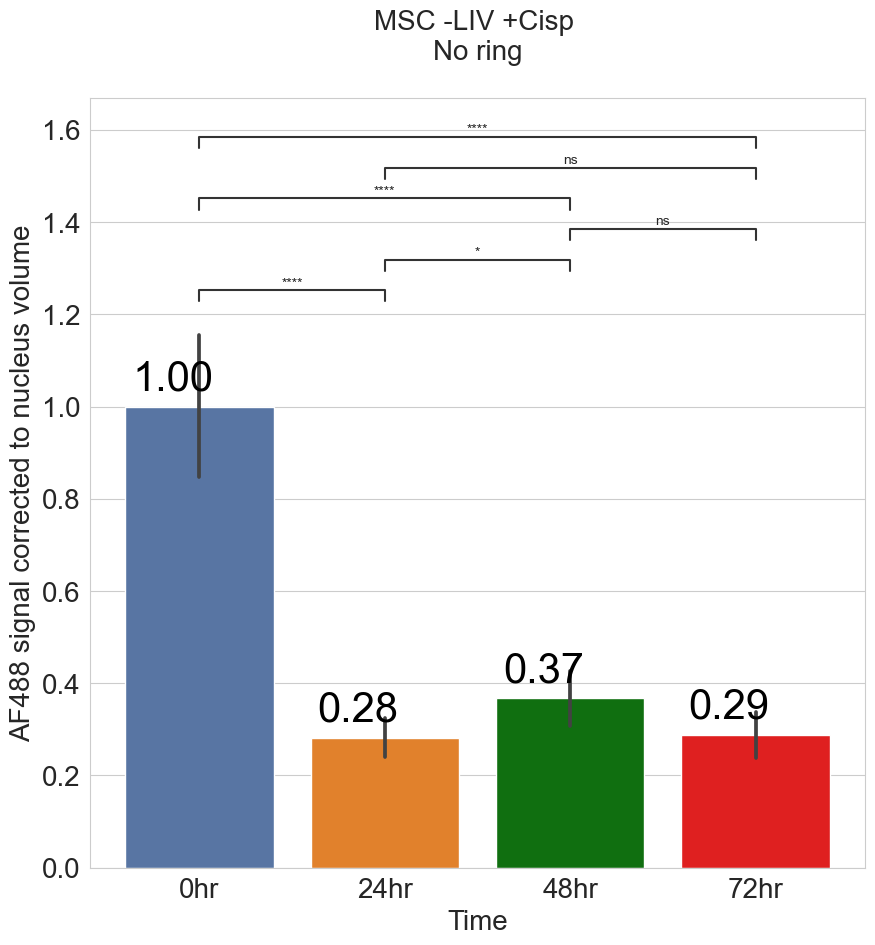

In [294]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': mcs_plus_cisp_minus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('MSC -LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal corrected to nucleus volume', fontsize=20)

plt.savefig('figures/volume_corrected_MSC -LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.467e-11 U_stat=1.123e+03
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.315e-04 U_stat=3.500e+02
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.753e-03 U_stat=4.800e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.079e-10 U_stat=9.310e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.090e-07 U_stat=7.190e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.071e-15 U_stat=1.714e+03


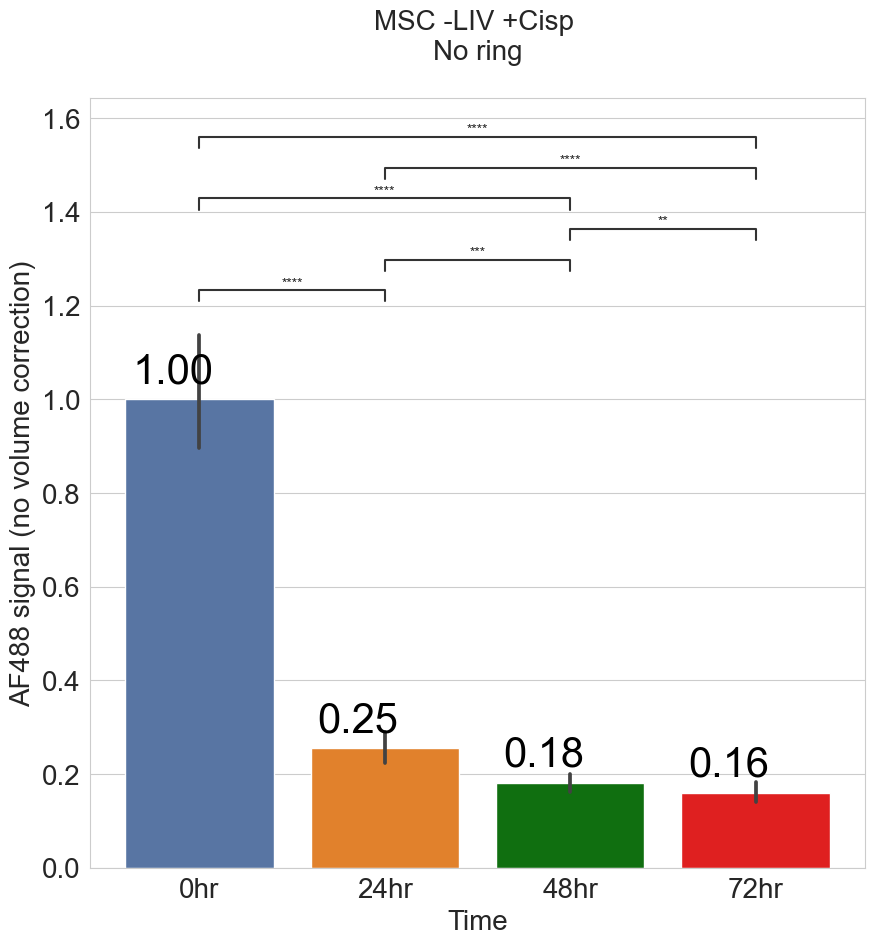

In [295]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 av_signal_in_nuc_area_3D',
            'data': mcs_plus_cisp_minus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('MSC -LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal (no volume correction)', fontsize=20)

plt.savefig('figures/av_signal_MSC -LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.900e-02 U_stat=4.000e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.073e-05 U_stat=6.200e+01
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.771e-01 U_stat=3.930e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.429e-08 U_stat=7.300e+01
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.723e-03 U_stat=2.370e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.479e-06 U_stat=3.560e+02


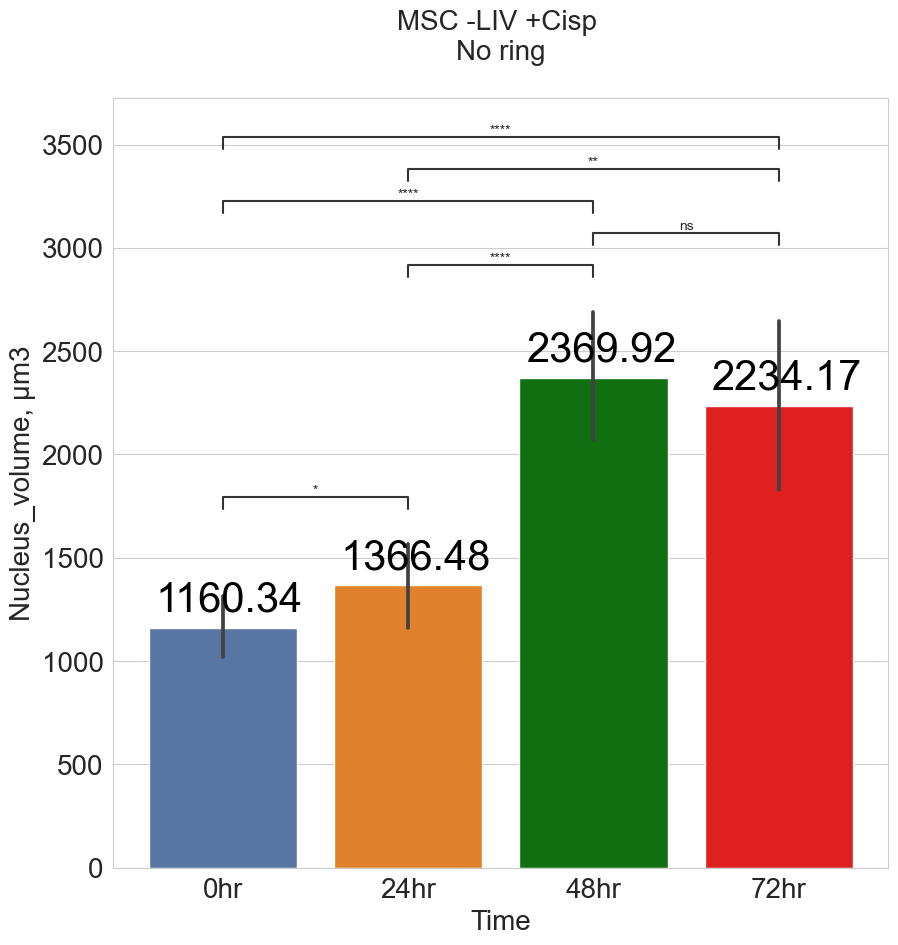

In [296]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': mcs_plus_cisp_minus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('MSC -LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/MSC -LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

## MSC +LIV +Cisp


In [297]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr'),
                           ('0hr','24hr'),
                           ('24hr','48hr')]

In [298]:
# Filter DataFrame to only include '- Doxy +Crisp +LIV' group without rings
msc_plus_cisp_plus_liv_no_ring_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['Cell_type'] == 'MSC') & (filtered_df['LIV'] == '+LIV') & (filtered_df['AF594-T2 ring intensity coef'] < RING_CUTT_OFF_COEF)].copy()

msc_plus_cisp_plus_liv_df = filtered_df[(filtered_df['Doxy'] == '-doxy') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['Cell_type'] == 'MSC') & (filtered_df['LIV'] == '+LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_vol_cor = msc_plus_cisp_plus_liv_no_ring_df[msc_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
msc_plus_cisp_plus_liv_no_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr_vol_cor

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_without_cor = msc_plus_cisp_plus_liv_no_ring_df[msc_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
msc_plus_cisp_plus_liv_no_ring_df.loc[:, 'AF488-T3 av_signal_in_nuc_area_3D'] /= average_0hr_without_cor

print(f"Total MSC -LIV +Cisp: {len(msc_plus_cisp_plus_liv_df)}")
print(f"No ring MSC -LIV +Cisp: {len(msc_plus_cisp_plus_liv_no_ring_df)}\n"
      f"0hr: {len(msc_plus_cisp_plus_liv_no_ring_df[msc_plus_cisp_plus_liv_no_ring_df['Time'] == '0hr'])}\n"
      f"24hr: {len(msc_plus_cisp_plus_liv_no_ring_df[msc_plus_cisp_plus_liv_no_ring_df['Time'] == '24hr'])}\n"
      f"48hr: {len(msc_plus_cisp_plus_liv_no_ring_df[msc_plus_cisp_plus_liv_no_ring_df['Time'] == '48hr'])}\n"
      f"72hr: {len(msc_plus_cisp_plus_liv_no_ring_df[msc_plus_cisp_plus_liv_no_ring_df['Time'] == '72hr'])}\n")

Total MSC -LIV +Cisp: 97
No ring MSC -LIV +Cisp: 72
0hr: 33
24hr: 27
48hr: 12
72hr: 0



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.408e-01 U_stat=4.510e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.959e-01 U_stat=2.050e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.087e-01 U_stat=2.610e+02


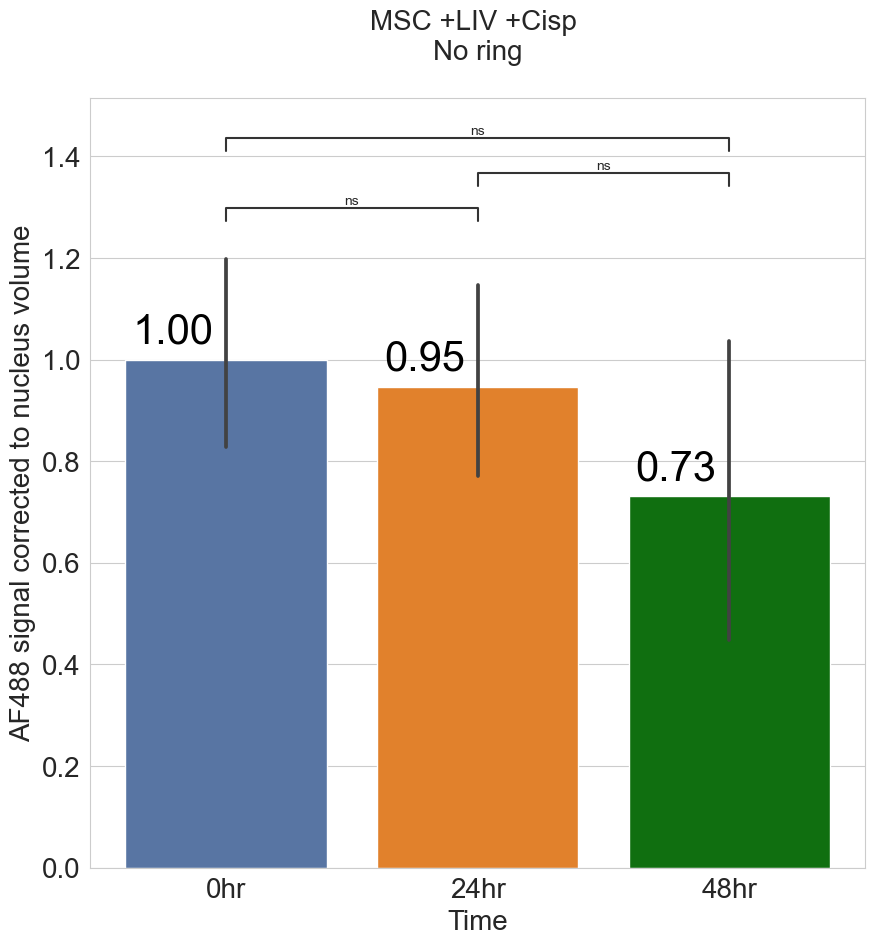

In [299]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': msc_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('MSC +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal corrected to nucleus volume', fontsize=20)

plt.savefig('figures/volume_corrected_MSC +LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.900e-03 U_stat=6.550e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.694e-01 U_stat=1.920e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.277e-03 U_stat=3.240e+02


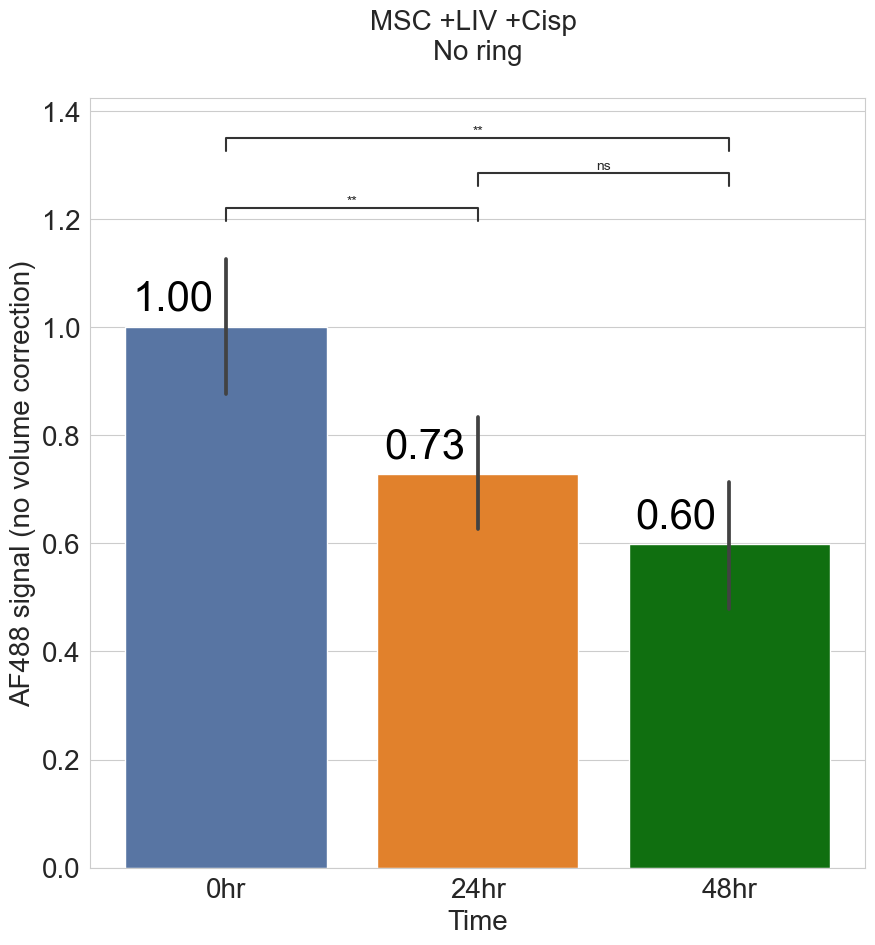

In [300]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 av_signal_in_nuc_area_3D',
            'data': msc_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('MSC +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal (no volume correction)', fontsize=20)

plt.savefig('figures/av_signal_MSC +LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.238e-02 U_stat=3.010e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.320e-01 U_stat=2.120e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:8.675e-01 U_stat=1.910e+02


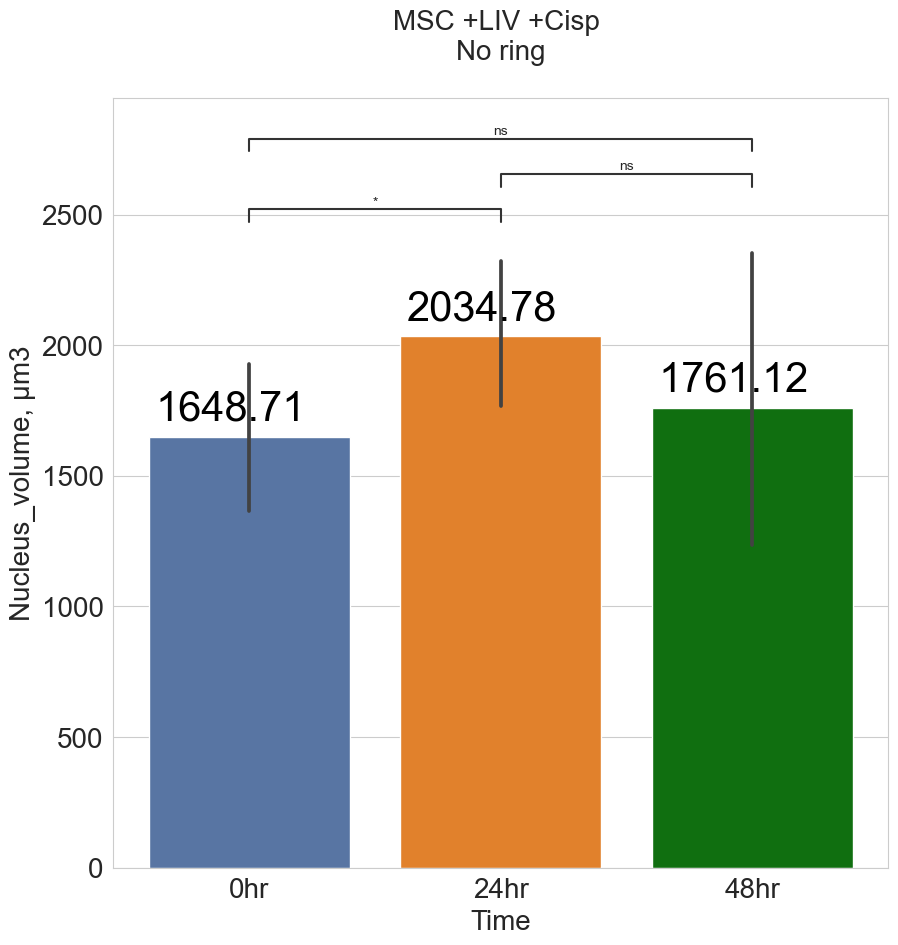

In [301]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': msc_plus_cisp_plus_liv_no_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('MSC +LIV +Cisp \nNo ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/MSC +LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

## +Doxy -LIV +Cisp

In [302]:
# Adjust significance comparisons for '+LIV' group only
significanceComparisons = [('0hr','48hr'),
                           ('0hr','24hr'),
                           ('0hr','72hr'),
                           ('24hr','48hr'),
                           ('24hr','72hr'),
                           ('48hr','72hr')]

In [303]:
# Filter DataFrame to only include '+Doxy +Crisp -LIV' group with rings
plus_doxy_plus_cisp_minus_liv_with_ring_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['Cell_type'] == 'KASH') & (filtered_df['LIV'] == '-LIV') & (filtered_df['AF594-T2 ring intensity coef'] >= RING_CUTT_OFF_COEF)].copy()


plus_doxy_plus_cisp_minus_liv_df = filtered_df[(filtered_df['Doxy'] == '+doxy') & (filtered_df['Cell_type'] == 'KASH') & (filtered_df['Treatment'] == 'cisp') & (filtered_df['LIV'] == '-LIV') ].copy()

# Normalize 'AF488-T3 av_signal_in_nuc_area_3D' by average of '0hr' group
average_0hr_vol_cor = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 Volume_corrected_signal_in_nuc_area_3D'].mean()
plus_doxy_plus_cisp_minus_liv_with_ring_df.loc[:, 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D'] /= average_0hr_vol_cor

average_0hr_without_cor = plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr']['AF488-T3 av_signal_in_nuc_area_3D'].mean()
plus_doxy_plus_cisp_minus_liv_with_ring_df.loc[:, 'AF488-T3 av_signal_in_nuc_area_3D'] /= average_0hr_without_cor

print(f"Total +Doxy -LIV +Cisp: {len(plus_doxy_plus_cisp_minus_liv_df)}")
print(f"With ring +Doxy -LIV +Cisp: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df)}\n"
      f"0hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '0hr'])}\n"
      f"24hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '24hr'])}\n"
      f"48hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '48hr'])}\n"
      f"72hr: {len(plus_doxy_plus_cisp_minus_liv_with_ring_df[plus_doxy_plus_cisp_minus_liv_with_ring_df['Time'] == '72hr'])}")


Total +Doxy -LIV +Cisp: 153
With ring +Doxy -LIV +Cisp: 93
0hr: 25
24hr: 20
48hr: 21
72hr: 27


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.171e-04 U_stat=9.500e+01
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.478e-04 U_stat=6.900e+01
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:4.168e-02 U_stat=3.820e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.414e-08 U_stat=9.000e+00
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.464e-01 U_stat=2.020e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.307e-05 U_stat=9.900e+01


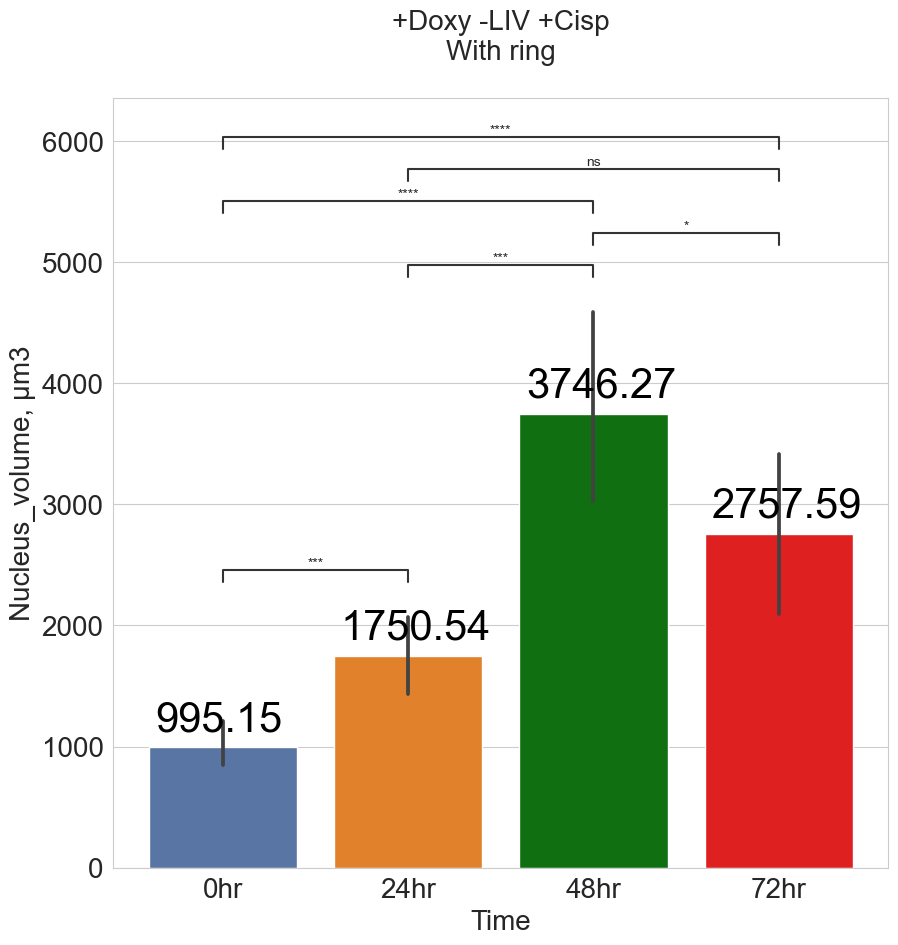

In [304]:
fig_args = {'x': 'Time',
            'y': 'Nucleus_volume, cubic_micrometre',
            'data': plus_doxy_plus_cisp_minus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy -LIV +Cisp\nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Nucleus_volume, µm3', fontsize=20)

plt.savefig('figures/+Doxy -LIV +Cisp Nucleus_volume.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:5.757e-01 U_stat=2.250e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:2.377e-03 U_stat=9.300e+01
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.059e-02 U_stat=3.710e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.400e-04 U_stat=1.120e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:3.068e-01 U_stat=2.220e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.639e-01 U_stat=2.610e+02


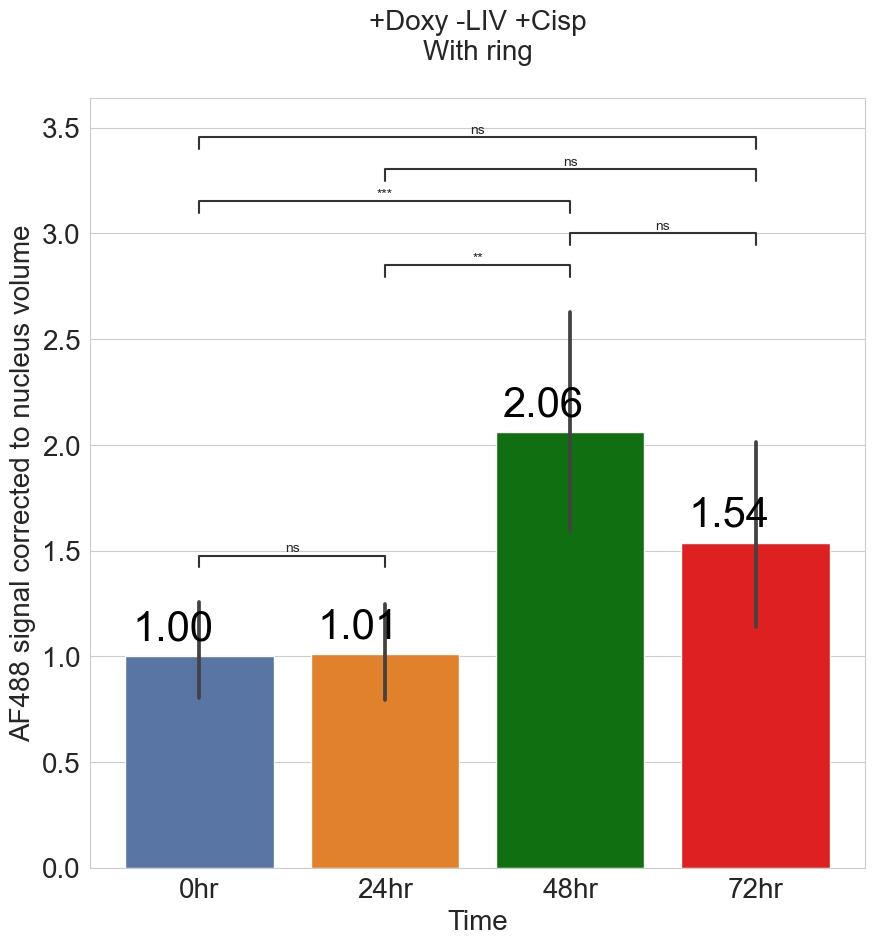

In [305]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 Volume_corrected_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_minus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy -LIV +Cisp\nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal corrected to nucleus volume', fontsize=20)

plt.savefig('figures/volume_corrected_KASH+Doxy -LIV +Cisp.png', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0hr vs. 24hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.523e-06 U_stat=4.610e+02
24hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.066e-01 U_stat=2.150e+02
48hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:9.668e-01 U_stat=2.810e+02
0hr vs. 48hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.946e-07 U_stat=4.990e+02
24hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.880e-01 U_stat=2.830e+02
0hr vs. 72hr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.881e-08 U_stat=6.450e+02


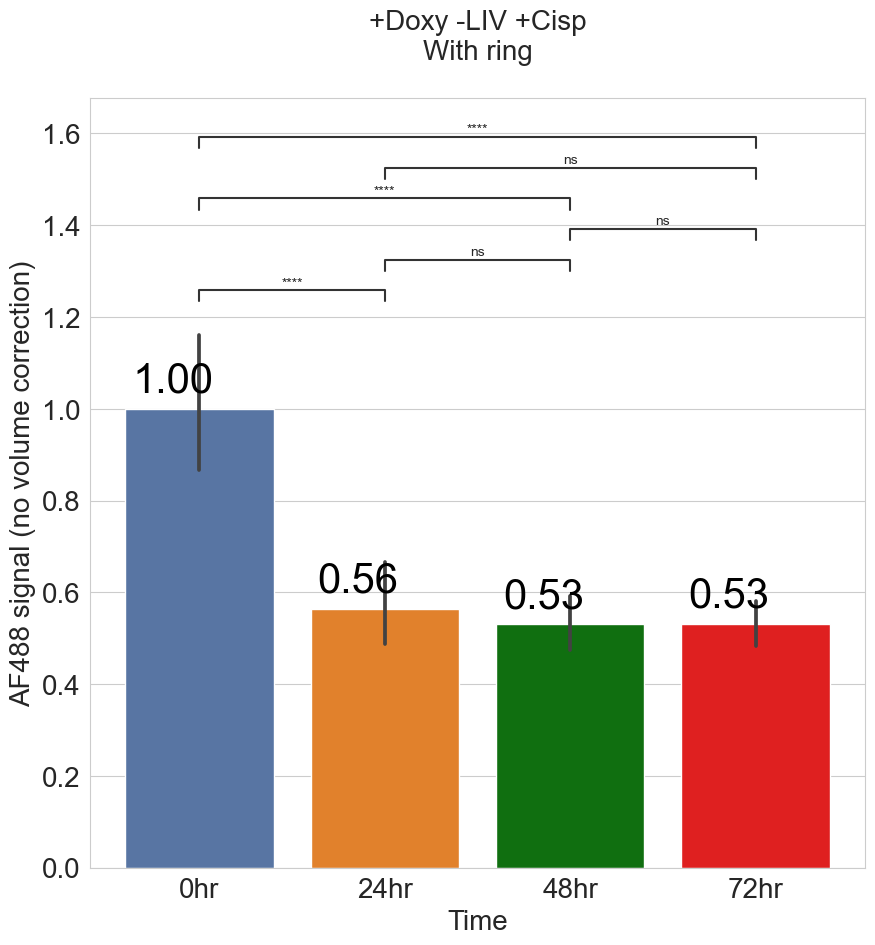

In [306]:
fig_args = {'x': 'Time',
            'y': 'AF488-T3 av_signal_in_nuc_area_3D',
            'data': plus_doxy_plus_cisp_minus_liv_with_ring_df,
            'dodge': True,
            'palette': pal}

fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(ax=ax, **fig_args)

# Annotate the bars with their actual mean values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x(), p.get_height()),
                ha='left', va='center', fontsize=30, color='black',
                xytext=(5, 20),  # Add a slight horizontal offset to prevent overlap with the bar
                textcoords='offset points')

# You might need to import the StatAnnotator
annotator = Annotator(ax=ax, pairs=significanceComparisons, **fig_args)
annotator.configure(**configuration).apply_test().annotate()

# To modify title size use
ax.set_title('+Doxy -LIV +Cisp\nWith ring\n', fontsize=20)

# Set label size - this modifies both x and y axis labels
ax.tick_params(labelsize=20)

# To modify x and y labels size use
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('AF488 signal (no volume correction)', fontsize=20)

plt.savefig('figures/av_signal_KASH+Doxy -LIV +Cisp.png', dpi=300, bbox_inches='tight')